# Analysis

This notebook contains the analysis of the data tracked on
[Weights & Biases](https://wandb.ai/).


## Setup

---

We will first setup everything so that we can easily analyse the experiment
results. This includes importing the necessary libraries, setting paths, loading
the experiment results from W&B.


In [105]:
# ruff: noqa
%load_ext autoreload
%autoreload 2

# Bult-in modules
import os
import sys

sys.path.insert(0, "..")

# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# External modules
# - Data Representation
import pandas as pd
import numpy as np

# - Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import plotnine as pn

# - Machine Learning
import torch

# - Experiment Configuration and Logging
import wandb

# Custom modules
from utils import eval_utils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
# Setup of global variables
ROOT_DIR = os.path.dirname(os.path.abspath("."))
ARTIFACT_DIR = os.path.join(ROOT_DIR, "artifacts")
FIGURE_DIR = os.path.join(ROOT_DIR, "report", "figures")
TABLE_DIR = os.path.join(ROOT_DIR, "report", "tables")

os.makedirs(FIGURE_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

METHODS = ["baseline", "baseline_pp", "matchingnet", "protonet", "maml"]
METHODS_WITH_SOT = []
for method in METHODS:
    METHODS_WITH_SOT.append(method)
    METHODS_WITH_SOT.append(method + "_sot")

STYLED_METHODS = ["Baseline", "Baseline++", "MatchingNet", "ProtoNet", "MAML"]
STYLED_METHODS_WITH_SOT = []
for method in STYLED_METHODS:
    STYLED_METHODS_WITH_SOT.append(method)
    STYLED_METHODS_WITH_SOT.append(method + " (SOT)")

styled_methods_dict = dict(zip(METHODS, STYLED_METHODS))


def get_name(name, sot=False):
    return styled_methods_dict[name] + (" (SOT)" if sot else "")

In [107]:
# Settings
REPORT = True
sns.set_style("dark")
sns.set_palette("gist_stern" if REPORT else "RdBu")

In [108]:
# Initialize wandb
WANDB_PROJECT = "few-shot-benchmark"
WANDB_ENTITY = "metameta-learners"

# Initialize W&B API
api = wandb.Api()

# Get all runs
runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")

## Experiment 1: Benchmark

---

All models on all datasets with and without SOT for fixed few-shot learning
setting (5-way 5-shot).


### Loading Experiment Data


In [109]:
# Get all runs for experiment `benchmark`
GROUP = "new-tuned-benchmark"

exp1_runs = [run for run in runs if run.group == GROUP and run.state == "finished"]
print(f"✅ Found {len(exp1_runs)} runs")

✅ Found 848 runs


Next, we'll load all runs from the given experiment group into a single
dataframe.


In [110]:
df_exp1 = utils.load_to_df(exp1_runs)
print(f"✅ Loaded {len(df_exp1)} runs.")

df_exp1.head()

✅ Loaded 848 runs.


info                 config  \
                                            name     runtime    dataset   
id                                                                        
xgmh9m8q         maml-swissprot-sot-5-way-5-shot  147.107794  swissprot   
rf26slyf  baseline_pp-swissprot-sot-5-way-5-shot  512.468140  swissprot   
0csum1la  baseline_pp-swissprot-sot-5-way-5-shot  495.972128  swissprot   
o4ggueni  baseline_pp-swissprot-sot-5-way-5-shot  773.452602  swissprot   
xwd181zi         maml-swissprot-sot-5-way-5-shot  809.499200  swissprot   

                                                 eval             \
               method use_sot n_way n_shot    val/acc train/loss   
id                                                                 
xgmh9m8q         maml    True     5      5  20.000000        NaN   
rf26slyf  baseline_pp    True     5      5  52.513333   8.383984   
0csum1la  baseline_pp    True     5      5  73.466667   8.715089   
o4ggueni  baseline_pp    True     5      5  68.040000   8.606066   
xwd181zi         maml    True     5      5  36.260000   1.562087   

                        ...                                                   \
         train/acc_std  ...  train/acc val/acc_std test/acc_std train/acc_ci   
id                      ...                                                    
xgmh9m8q      0.000000  ...  20.000000    0.000000     0.000000     0.000000   
rf26slyf     16.226693  ...  51.633333   14.799206     8.912311     1.298406   
0csum1la     12.770626  ...  71.666667   11.677138    10.212826     1.021863   
o4ggueni     12.774280  ...  65.866667   11.537695    10.172798     1.022155   
xwd181zi      9.982275  ...  37.086667   10.768429    10.205600     0.798748   

                                 hparams                                   
         test/acc_ci val/acc_ci       lr feat_dim sot_reg sot_dist_metric  
id                                                                         
xgmh9m8q    0.000000   0.000000  0.00010     1024    0.01       euclidean  
rf26slyf    0.713133   1.184183  0.00001     1024    1.00       euclidean  
0csum1la    0.817196   0.934366  0.00001     1024    0.10       euclidean  
o4ggueni    0.813993   0.923208  0.00001     1024    0.01       euclidean  
xwd181zi    0.816618   0.861654  0.00010     1024    0.01          cosine  

[5 rows x 22 columns]

We check the number of runs for each unique experiment to verify that we have
the same number of runs for each experiment.


In [111]:
# Number of runs per experiment
experiment_config = [("config", c) for c in df_exp1.config.columns]
df_exp1.groupby(experiment_config).size().reset_index(name="count")

,"(config, dataset)","(config, method)","(config, use_sot)","(config, n_way)","(config, n_shot)",count
0,swissprot,baseline,False,5,5,1
1,swissprot,baseline,True,5,5,88
2,swissprot,baseline_pp,False,5,5,1
3,swissprot,baseline_pp,True,5,5,98
4,swissprot,maml,False,5,5,1
5,swissprot,maml,True,5,5,192
6,swissprot,matchingnet,False,5,5,1
7,swissprot,matchingnet,True,5,5,77
8,swissprot,protonet,False,5,5,1
9,swissprot,protonet,True,5,5,91


### Grouping

Each experiment is uniquely identified by the following parameters:

- `dataset`: The dataset used (`swissprot`, `tabula_muris`)
- `method`: The model used (`baseline`, `baseline_pp`, `protonet`,
  `matchingnet`, `maml`)
- `use_sot`: Whether to include the SOT module (`True`, `False`)
- `n_way`: The number of classes in each episode
- `n_shot`: The number of support samples per class in each episode

For each experiment setting, there are multiple trained models because of
hyper-parameter tuning. We will group the runs by the above parameters and only
use the best-performing model on the validation set for the following analysis.


In [112]:
# Group tuning runs by experiment configuration
df_exp1_best = utils.get_best_run(df_exp1, metric=("eval", "val/acc"))
print(f"✅ Filtered to {len(df_exp1_best)} best runs.")

# Let's also save two separate dataframes for the two different datasets
df_exp1_best_tm = df_exp1_best[df_exp1_best[("config", "dataset")] == "tabula_muris"]
df_exp1_best_sp = df_exp1_best[df_exp1_best[("config", "dataset")] == "swissprot"]

df_exp1_best.head()

✅ Filtered to 20 best runs.


info                    config  \
                                            name     runtime       dataset   
ksnjtaqy         maml-swissprot-sot-5-way-5-shot  385.251713     swissprot   
alzdecfn  baseline_pp-swissprot-sot-5-way-5-shot  434.110657     swissprot   
ejw5lb64  baseline-tabula_muris-sot-5-way-5-shot  321.716063  tabula_muris   
8z0kn6d4     protonet-swissprot-sot-5-way-5-shot   23.483144     swissprot   
l7rba1mz  matchingnet-swissprot-sot-5-way-5-shot  133.146713     swissprot   

                                                 eval             \
               method use_sot n_way n_shot    val/acc train/loss   
ksnjtaqy         maml    True     5      5  77.540000   0.424841   
alzdecfn  baseline_pp    True     5      5  75.066667   8.740771   
ejw5lb64     baseline    True     5      5  90.986667   3.232602   
8z0kn6d4     protonet    True     5      5  76.640000   0.663394   
l7rba1mz  matchingnet    True     5      5  78.080000   0.261582   

                        ...                                                   \
         train/acc_std  ...  train/acc val/acc_std test/acc_std train/acc_ci   
ksnjtaqy     10.082326  ...  86.326667   11.759892     8.692963     0.806754   
alzdecfn     12.241975  ...  73.973333   11.308207    10.077828     0.979562   
ejw5lb64      8.774620  ...  92.706667    8.506458     8.235198     0.702116   
8z0kn6d4     10.902526  ...  84.960000   11.410685     9.608771     0.872384   
l7rba1mz     10.075535  ...  87.940000   10.944417     9.243374     0.806211   

                                 hparams                                   
         test/acc_ci val/acc_ci       lr feat_dim sot_reg sot_dist_metric  
ksnjtaqy    0.695582   0.940987  0.10000      512     0.1          cosine  
alzdecfn    0.806394   0.904845  0.00001     1024     0.1          cosine  
ejw5lb64    0.658953   0.680658  0.00010     1024     0.1          cosine  
8z0kn6d4    0.768862   0.913045  0.01000      512     0.1       euclidean  
l7rba1mz    0.739624   0.875736  0.00010      512     1.0          cosine  

[5 rows x 22 columns]

### Train / Val / Test Performance for all models

Here, we plot a simple bar plot for all methods (5 methods, each with and
without SOT) on all three splits (train, val, test). Performances are shown in
two separate plots for Swissprot and Tabula Muris


✅ Saved figure to /Users/adam/school/epfl/deeplearning_biomedicine/few-shot-benchmark/report/figures.


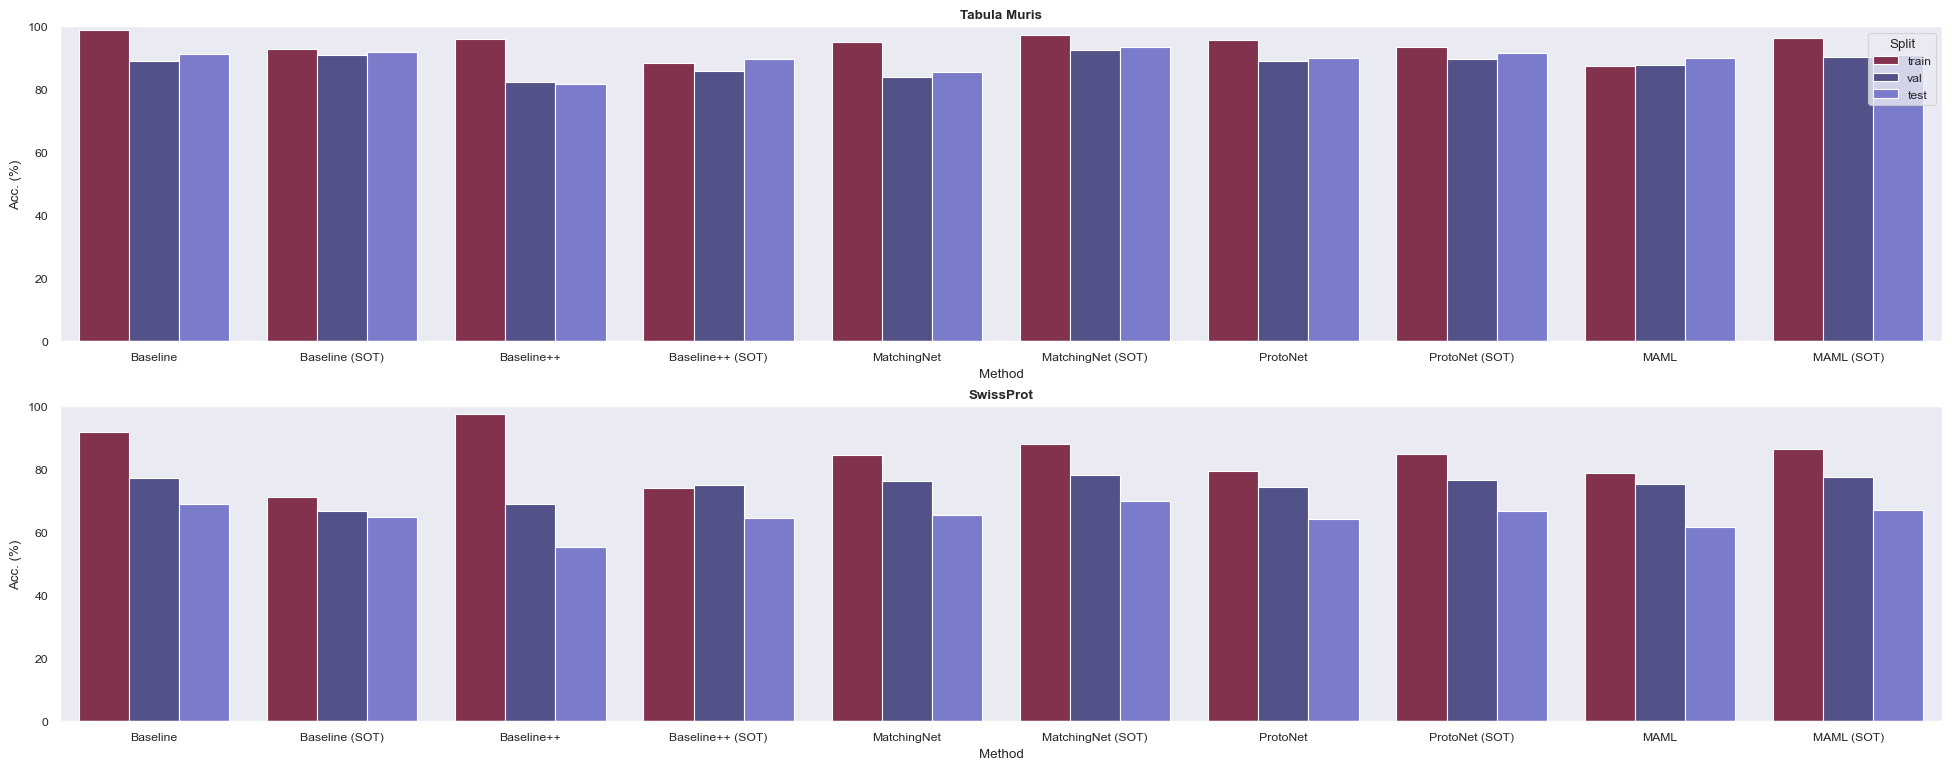

In [113]:
# Performance by split for all methods
fig, axs = plt.subplots(nrows=2, figsize=(20, 8))
fig.tight_layout(pad=3.0)


def pivot_acc(df):
    tmp = []
    for i, best_model in df.iterrows():
        for split in ["train", "val", "test"]:
            method_name = get_name(
                best_model[("config", "method")], best_model[("config", "use_sot")]
            )
            tmp.append(
                {
                    "method": method_name,
                    "split": split,
                    "acc": best_model[("eval", f"{split}/acc")],
                }
            )
    return pd.DataFrame(tmp)


sns.barplot(
    pivot_acc(df_exp1_best_tm),
    x="method",
    y="acc",
    hue="split",
    order=STYLED_METHODS_WITH_SOT,
    ax=axs[0],
)
sns.barplot(
    pivot_acc(df_exp1_best_sp),
    x="method",
    y="acc",
    hue="split",
    order=STYLED_METHODS_WITH_SOT,
    ax=axs[1],
)
# Set title
axs[0].set_title("Tabula Muris", fontweight="bold")
axs[1].set_title("SwissProt", fontweight="bold")

# Disable legend on first subplot
axs[0].get_legend().set_title("Split")
axs[1].get_legend().remove()

# Set y-axis limits
axs[0].set_ylim(0, 100)
axs[1].set_ylim(0, 100)

for ax in axs:
    ax.set_xlabel("Method")
    ax.set_ylabel("Acc. (%)")
fig.savefig(os.path.join(FIGURE_DIR, "benchmark-split-perf.png"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

### Performance by method with and without SOT

Here, we compare the performance of the different methods with and without SOT.
The left subplot shows the test performance on the Tabula Muris dataset, while
the right subplot shows the test performance on the Swissprot dataset.


✅ Saved figure to /Users/adam/school/epfl/deeplearning_biomedicine/few-shot-benchmark/report/figures.


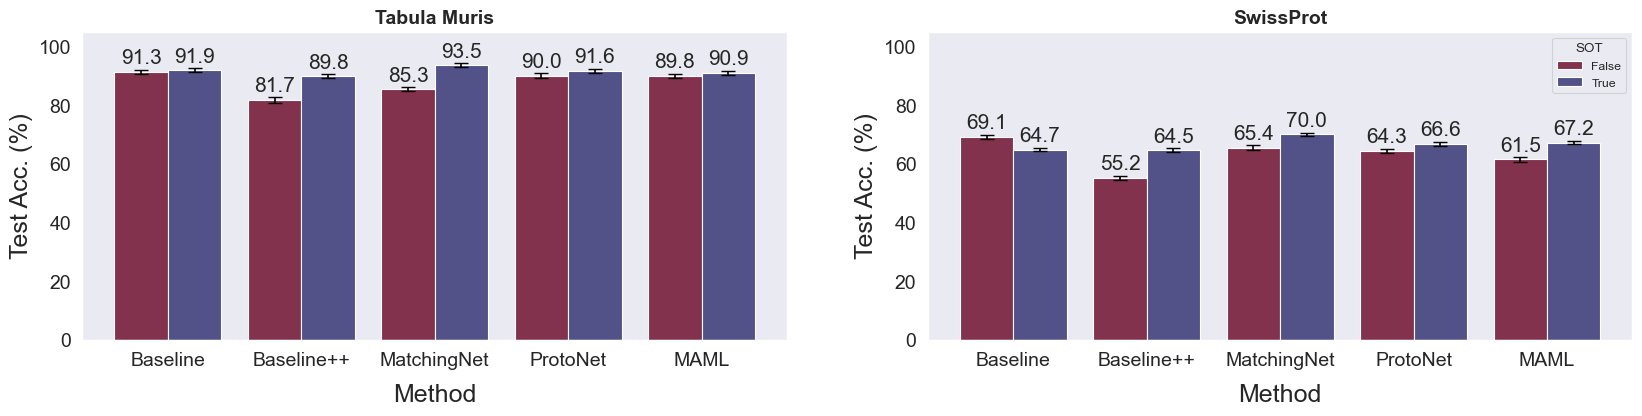

In [114]:
# Performance by method with and without SOT
fig, axs = plt.subplots(ncols=2, figsize=(20, 4))

sns.barplot(
    df_exp1_best_tm,
    x=("config", "method"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    order=METHODS,
    ax=axs[0],
)

sns.barplot(
    df_exp1_best_sp,
    x=("config", "method"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    ci="sd",
    order=METHODS,
    ax=axs[1],
)

# Set title
axs[0].set_title("Tabula Muris", fontweight="bold", fontsize=14)
axs[1].set_title("SwissProt", fontweight="bold", fontsize=14)

# Disable legend on first subplot
axs[0].get_legend().set_title("SOT")
axs[1].get_legend().set_title("SOT")

# Set axis labels
axs[0].set_xticklabels([get_name(name.get_text())
                       for name in axs[0].get_xticklabels()])
axs[1].set_xticklabels([get_name(name.get_text())
                       for name in axs[1].get_xticklabels()])

for ax in axs:
    ax.set_ylabel("Test Acc. (%)", fontsize=18)
    ax.set_xlabel("Method", fontsize=18)

# Remove legend in left plot
axs[0].get_legend().remove()

# Increasing tick size
axs[0].tick_params(labelsize=14)
axs[1].tick_params(labelsize=14)

axs[0].set_ylim(0, 105)
axs[1].set_ylim(0, 105)

# Adding padding between ticks and labels
axs[0].xaxis.labelpad = 10
axs[1].xaxis.labelpad = 10

# Add percentage to each bar
for p in axs[0].patches:
    axs[0].annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=15,
    )

# Add percentage to each bar
for p in axs[1].patches:
    axs[1].annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=15,
    )

# Add percentage to each bar
errors = df_exp1_best_sp[("eval", "test/acc_ci")]
df_exp1_best_sp["method_order"] = pd.Categorical(
    df_exp1_best_sp[("config", "method")], categories=METHODS, ordered=True
)
df_exp1_best_tm["method_order"] = pd.Categorical(
    df_exp1_best_tm[("config", "method")], categories=METHODS, ordered=True
)

# Sort by the custom order
sp_errors = df_exp1_best_sp.sort_values(["method_order", ("config", "use_sot")])[
    ("eval", "test/acc_ci")
]
tm_errors = df_exp1_best_tm.sort_values(["method_order", ("config", "use_sot")])[
    ("eval", "test/acc_ci")
]

for i, p in enumerate(axs[0].patches):
    axs[0].errorbar(
        p.get_x() + p.get_width() / 2.0,
        p.get_height(),
        yerr=sp_errors[i],
        fmt="none",
        color="black",
        capsize=5,
    )

for i, p in enumerate(axs[1].patches):
    axs[1].errorbar(
        p.get_x() + p.get_width() / 2.0,
        p.get_height(),
        yerr=tm_errors[i],
        fmt="none",
        color="black",
        capsize=5,
    )

# Save figure
name = "benchmark-method-perf.png" if REPORT else "present-benchmark-method-perf.png"
fig.savefig(os.path.join(FIGURE_DIR, name), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

### Hyperparameter Ablation

For each method including the SOT module we are searching over the following
hyperparameters:

- `lr`: The learning rate of the optimizer (`0.001`, `0.01`, `0.1`)
- `hidden_dim`: The hidden dimension of the backbone (`64`, `512`, `1024`)
- `sot_reg`: Regularization strength for the SOT module (`0.01`, `0.1`, `1.0`)
- `sot_dist`: The distance function used for the SOT module (`euclidean`,
  `cosine`)

This leads to a total of $3 \times 3 \times 3 \times 2 = 54$ different tuning
runs for each model. Let's first verify that we have all runs necessary and then
analyse the effect of the hyperparameters on the performance.


In [115]:
# Show the best hyper-parameters for each method
df_exp1_best[["config", "hparams"]]

config                                    hparams           \
               dataset       method use_sot n_way n_shot       lr feat_dim   
ksnjtaqy     swissprot         maml    True     5      5  0.10000      512   
alzdecfn     swissprot  baseline_pp    True     5      5  0.00001     1024   
ejw5lb64  tabula_muris     baseline    True     5      5  0.00010     1024   
8z0kn6d4     swissprot     protonet    True     5      5  0.01000      512   
l7rba1mz     swissprot  matchingnet    True     5      5  0.00010      512   
8mzybqid     swissprot     baseline    True     5      5  0.00010     1024   
2a14czw4  tabula_muris  baseline_pp    True     5      5  0.00100      512   
oyvujd17  tabula_muris         maml    True     5      5  0.10000     1024   
maj3wf6s  tabula_muris  matchingnet    True     5      5  0.00100      512   
9016homz  tabula_muris     protonet    True     5      5  0.10000     1024   
qzhe83ms  tabula_muris  baseline_pp   False     5      5  0.00100       64   
xi1i54pn  tabula_muris     baseline   False     5      5  0.00100       64   
q62pqvyt  tabula_muris         maml   False     5      5  0.00100       64   
nxtq9oub  tabula_muris  matchingnet   False     5      5  0.00100       64   
zje5iq09  tabula_muris     protonet   False     5      5  0.00100       64   
pntw5j33     swissprot  baseline_pp   False     5      5  0.00100      512   
1hqhvrwk     swissprot     baseline   False     5      5  0.00100      512   
yaoe00mz     swissprot         maml   False     5      5  0.00100      512   
2w89fken     swissprot     protonet   False     5      5  0.00100      512   
6wabx5ak     swissprot  matchingnet   False     5      5  0.00100      512   

                                  
         sot_reg sot_dist_metric  
ksnjtaqy    0.10          cosine  
alzdecfn    0.10          cosine  
ejw5lb64    0.10          cosine  
8z0kn6d4    0.10       euclidean  
l7rba1mz    1.00          cosine  
8mzybqid    0.10          cosine  
2a14czw4    0.10          cosine  
oyvujd17    0.01          cosine  
maj3wf6s    0.10          cosine  
9016homz    0.01          cosine  
qzhe83ms    0.10          cosine  
xi1i54pn    0.10          cosine  
q62pqvyt    0.10          cosine  
nxtq9oub    0.10          cosine  
zje5iq09    0.10          cosine  
pntw5j33    0.10          cosine  
1hqhvrwk    0.10          cosine  
yaoe00mz    0.10          cosine  
2w89fken    0.10          cosine  
6wabx5ak    0.10          cosine

We can see the following:

- Using `cosine` distance seems to be better across all methods and datasets.
- A regularisation parameter during the SOT phase of `0.1` is preferred across
  almost all methods and datasets.
- A low learning rate is generally preferred `0.001`
- Feature dimensions vary across methods and datasets.


Next, we visualise the effect of each hyperparameter individually for both
datasets separately. We are averaging the results of all tuning runs for each
hyperparameter value and method.


✅ Saved figure to /Users/adam/school/epfl/deeplearning_biomedicine/few-shot-benchmark/report/figures.
✅ Saved figure to /Users/adam/school/epfl/deeplearning_biomedicine/few-shot-benchmark/report/figures.


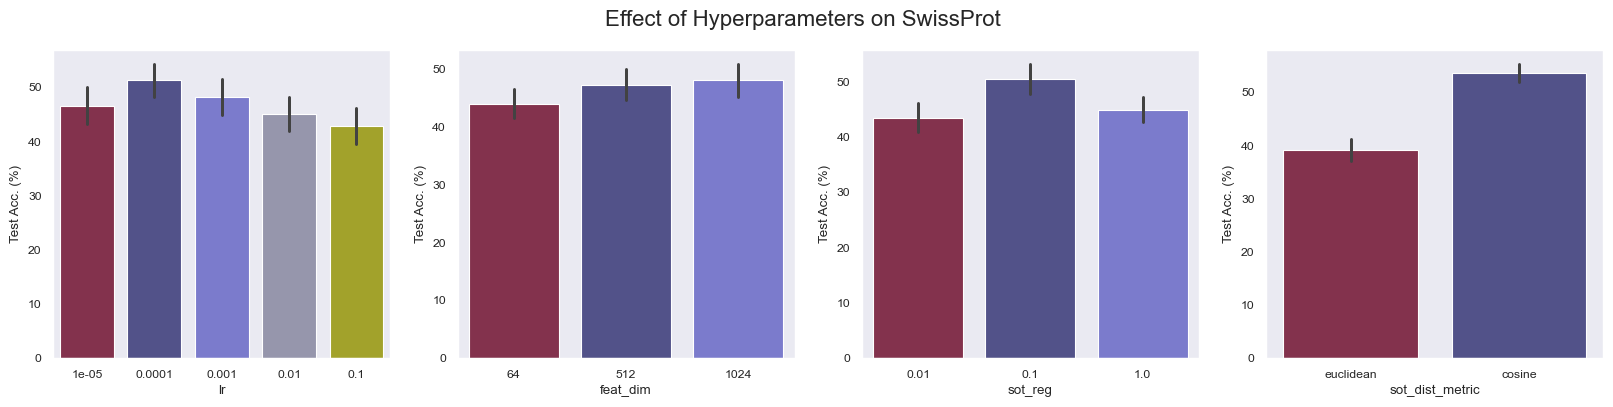

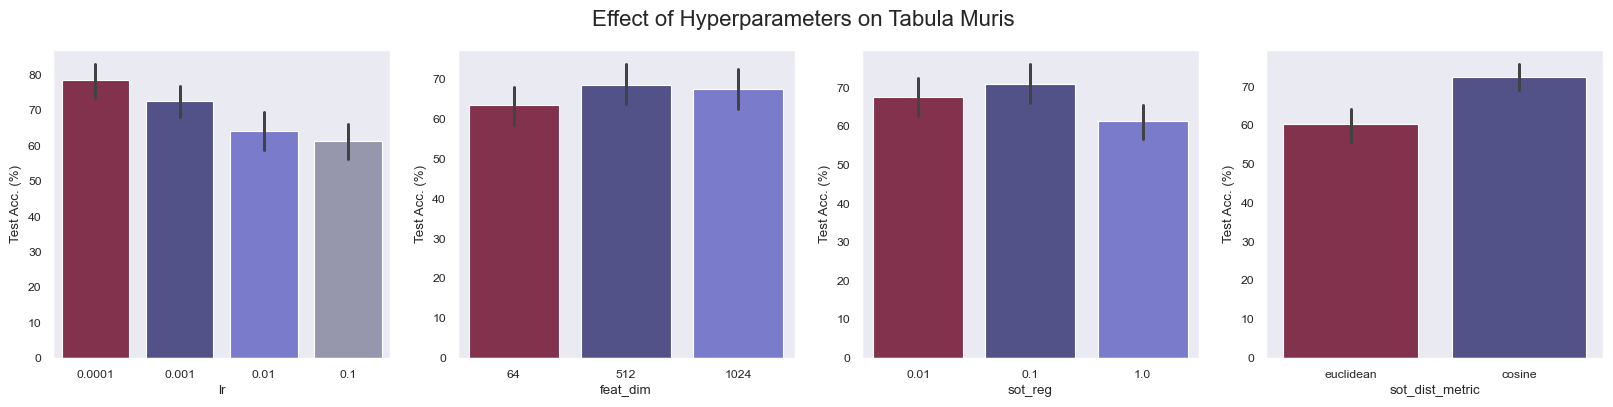

In [116]:
num_hparams = len(df_exp1.hparams.columns)

# Hyperparameter Effect on SwissProt for all methods
fig, axs = plt.subplots(ncols=num_hparams, figsize=(20, 4))
fig.suptitle("Effect of Hyperparameters on SwissProt", fontsize=16)
for ax, hparam in zip(axs, df_exp1.hparams.columns):
    utils.visualise_hparams(df_exp1, dataset="swissprot", hparam=hparam, ax=ax)

fig.savefig(os.path.join(FIGURE_DIR, "hparams-swissprot.png"),
            bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

# Hyperparameter Effect on Tabula Muris for all methods
fig, axs = plt.subplots(ncols=num_hparams, figsize=(20, 4))
fig.suptitle("Effect of Hyperparameters on Tabula Muris", fontsize=16)
for ax, hparam in zip(axs, df_exp1.hparams.columns):
    utils.visualise_hparams(
        df_exp1, dataset="tabula_muris", hparam=hparam, ax=ax)

fig.savefig(os.path.join(FIGURE_DIR, "hparams-tabula-muris.png"),
            bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

Next, we show the interaction of all hyper-parameters pairs and the method and
dataset performance.


✅ Saved figure to /Users/adam/school/epfl/deeplearning_biomedicine/few-shot-benchmark/report/figures.


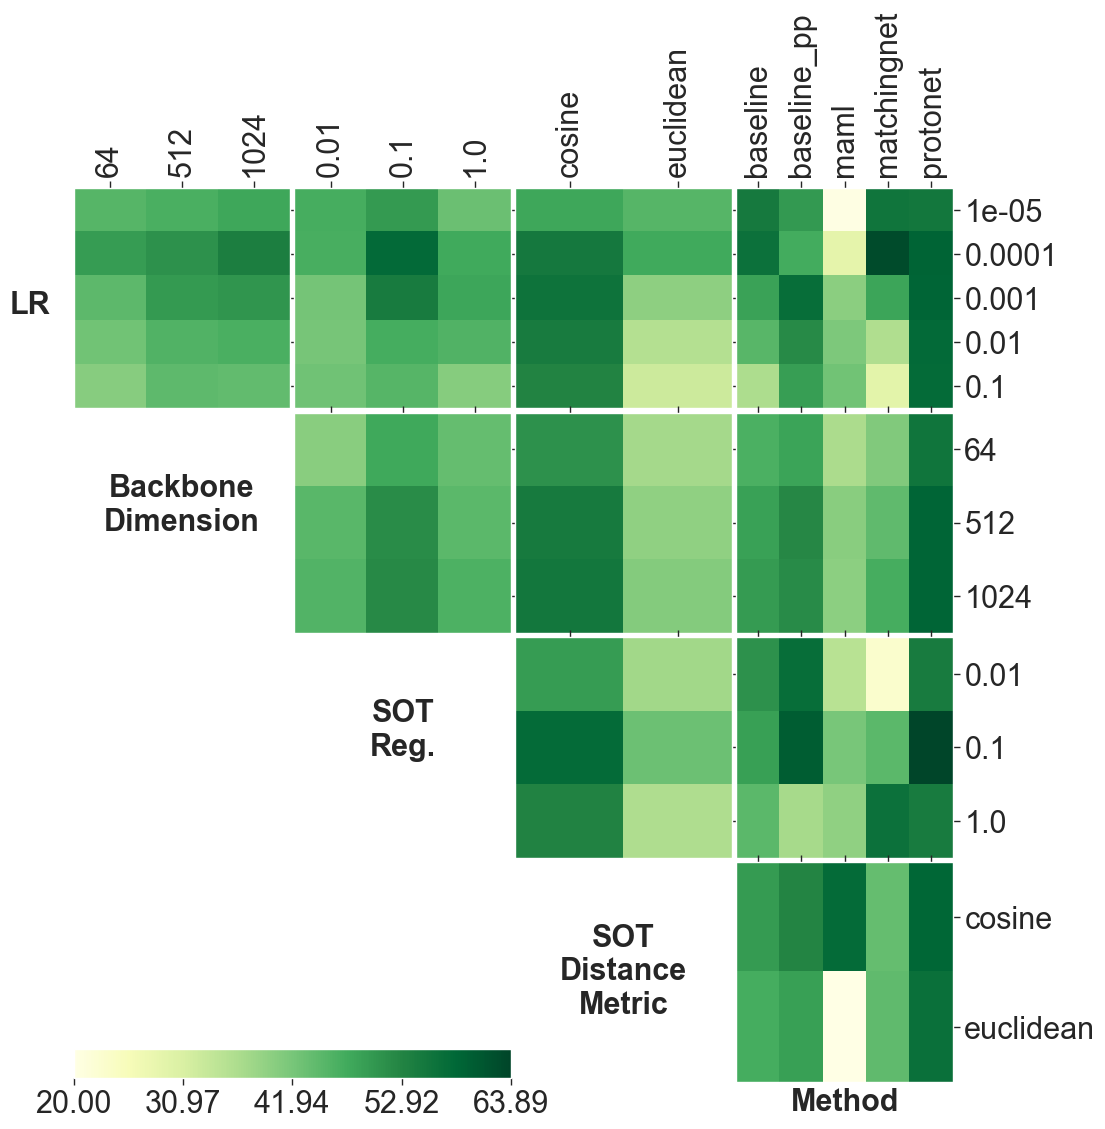

In [117]:
# Combined grid
param_cols = df_exp1[("hparams")].columns.tolist()
param_tuples = [("hparams", param) for param in param_cols]
param_tuples.append(("config", "method"))
# param_tuples.append(("config", "dataset"))
param_tuples
subset = df_exp1[
    df_exp1[("config", "use_sot")] 
    & df_exp1[("config","dataset")].isin(["swissprot"]) 
    # & (df_exp1[("eval", "test/acc")] >= 25.0)
]

rename_dict = {
    "lr": "LR",
    "feat_dim": "Backbone\nDimension",
    "sot_dist_metric": "SOT\nDistance\nMetric",
    "use_sot": "SOT",
    "sot_reg": "SOT\nReg.",
    "method": "Method",
    "dataset": "Dataset",
}

fig = utils.grid(
    subset, param_tuples, metric="mean", cmap="YlGn", figsize=(10, 10), rename_dict=rename_dict
)  # vmin, vmax automatically set

fig.savefig(
    os.path.join(FIGURE_DIR, "hparams-interaction-swissprot.png"),
    bbox_inches="tight",
    dpi=300,
)
print(f"✅ Saved figure to {FIGURE_DIR}.")

✅ Saved figure to /Users/adam/school/epfl/deeplearning_biomedicine/few-shot-benchmark/report/figures.


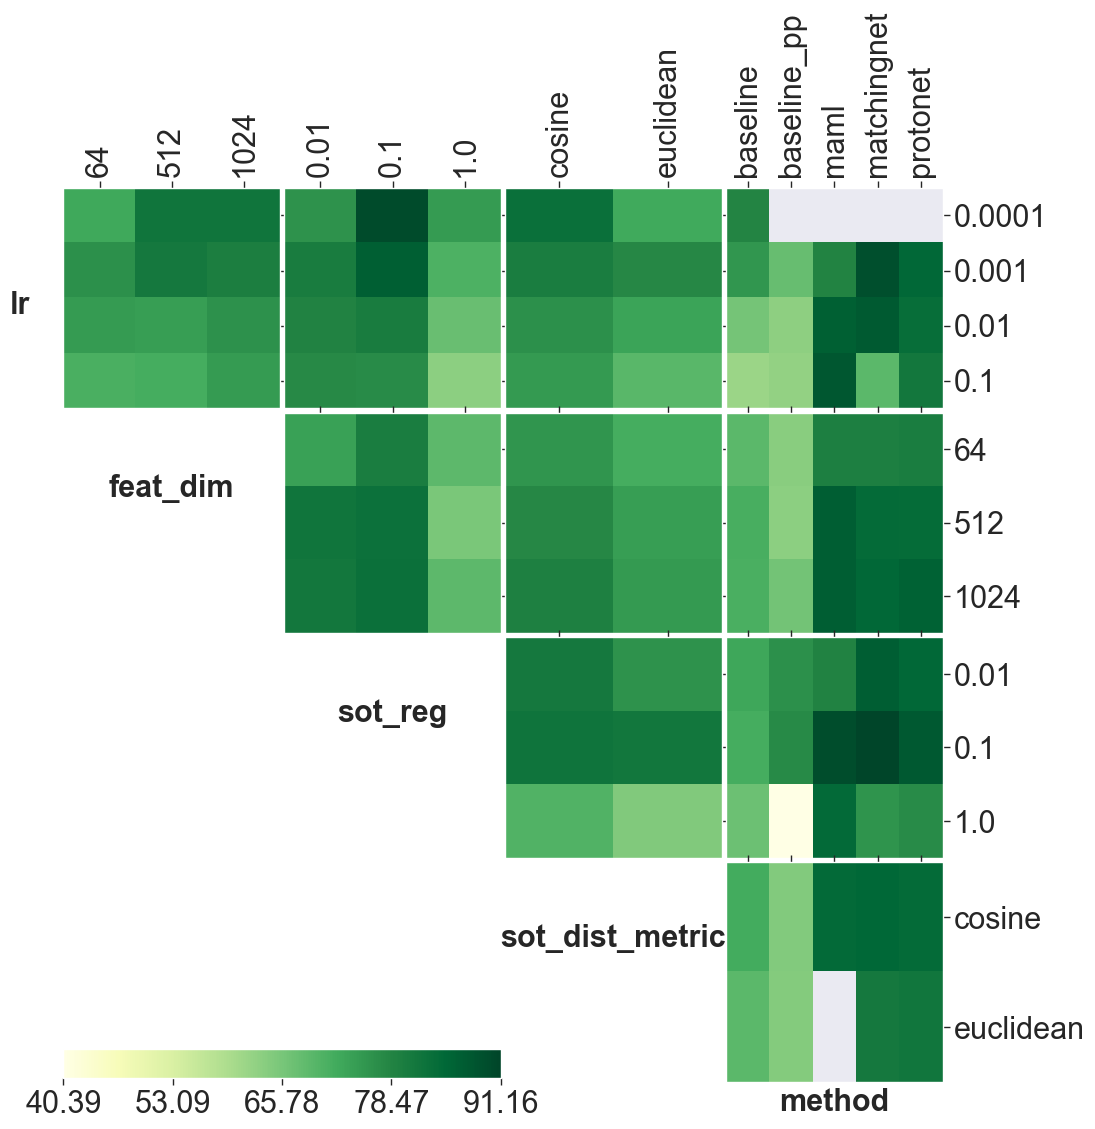

In [118]:
# Choose hyperparameters to visualise
param_cols = df_exp1[("hparams")].columns.tolist()
param_tuples = [("hparams", param) for param in param_cols]
param_tuples.append(("config", "method"))
# param_tuples.append(("config", "dataset"))
param_tuples
subset = df_exp1[
    df_exp1[("config", "use_sot")]
    & df_exp1[("config", "dataset")].isin(["tabula_muris"])
    & (df_exp1[("eval", "test/acc")] >= 25.0)
]
fig = utils.grid(
    subset, param_tuples, metric="mean", cmap="YlGn", figsize=(10, 10)
)  # vmin, vmax automatically set

fig.savefig(
    os.path.join(FIGURE_DIR, "hparams-interaction-tabula_muris.png"),
    bbox_inches="tight",
    dpi=300,
)
print(f"✅ Saved figure to {FIGURE_DIR}.")

✅ Saved figure to /Users/adam/school/epfl/deeplearning_biomedicine/few-shot-benchmark/report/figures.


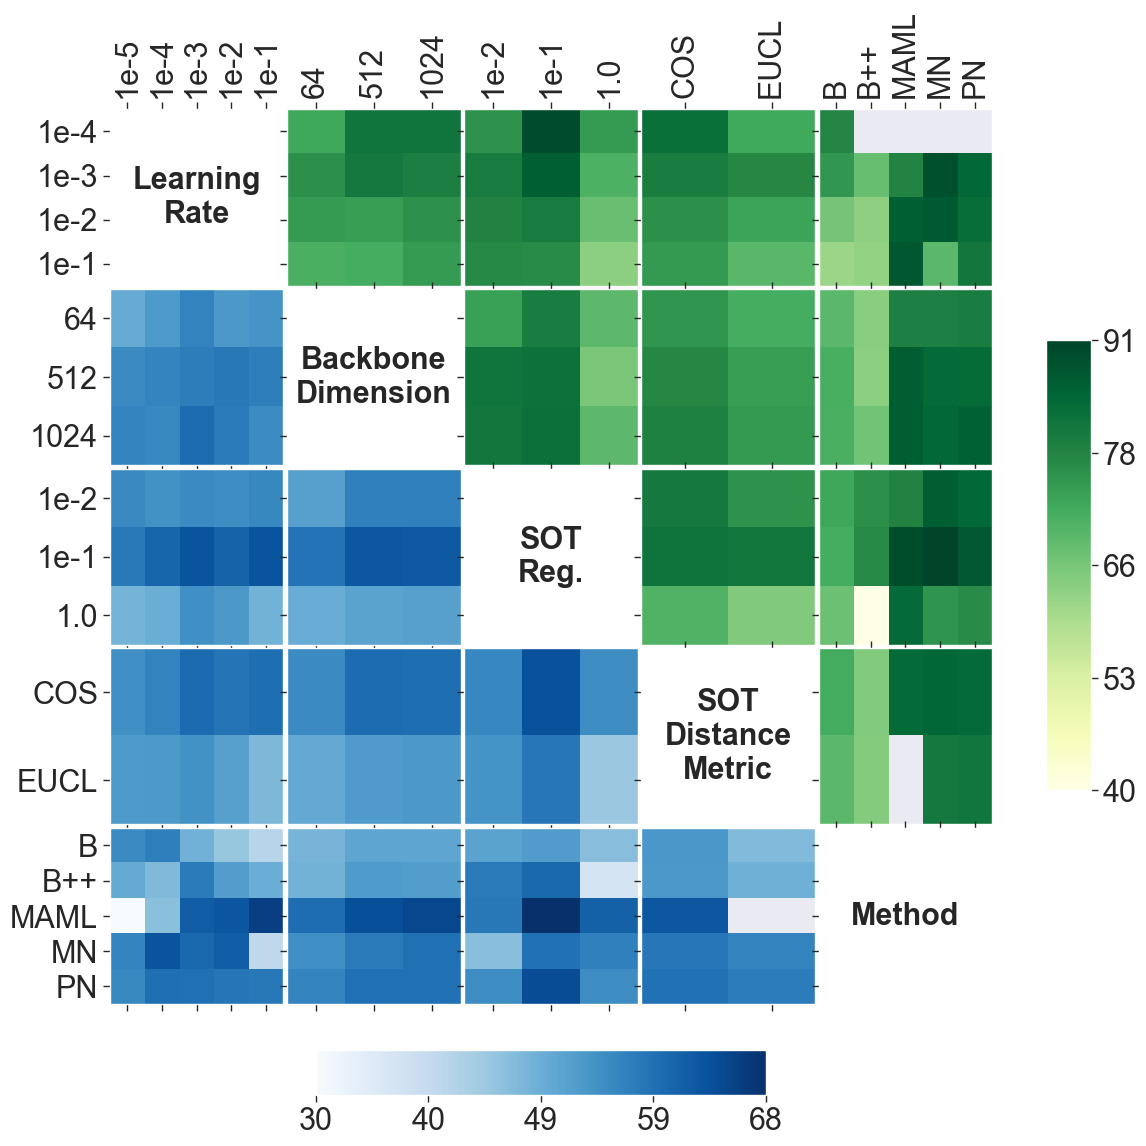

In [119]:
# combined grid
param_cols = df_exp1[("hparams")].columns.tolist()
param_tuples = [("hparams", param) for param in param_cols]
param_tuples.append(("config", "method"))
# param_tuples.append(("config", "dataset"))

rename_dict = {
    "lr": "Learning\nRate",
    "feat_dim": "Backbone\nDimension",
    "sot_dist_metric": "SOT\nDistance\nMetric",
    "sot_reg": "SOT\nReg.",
    "method": "Method",
    "dataset": "Dataset",
    "baseline":"B",
    "baseline_pp":"B++",
    "matchingnet":"MN",
    "protonet":"PN",
    "maml":"MAML",
    "euclidean":"EUCL",
    "cosine":"COS",
    0.1 : "1e-1",
    0.01 : "1e-2",
    0.001 : "1e-3",
    0.0001 : "1e-4",
    0.00001 : "1e-5",
}

subset1 = df_exp1[
    df_exp1[("config", "use_sot")]
    & df_exp1[("config", "dataset")].isin(["tabula_muris"])
    & (df_exp1[("eval", "test/acc")] >= 25.0)
    ]

subset2 = df_exp1[
    df_exp1[("config","use_sot")]
    & df_exp1[("config","dataset")].isin(["swissprot"])
    & (df_exp1[("eval","test/acc")] >= 25.0)
]

fig = utils.combined_grid(
    subset1,
    subset2,
    param_tuples,
    metric="mean",
    cmap1="YlGn",
    cmap2="Blues",
    figsize=(10, 10),
    rename_dict=rename_dict,
)  # vmin, vmax automatically set

name = (
    "hparams-interaction-combined.png"
    if REPORT
    else "present-hparams-interaction-combined.png"
)
fig.savefig(
    os.path.join(FIGURE_DIR, name),
    bbox_inches="tight",
    dpi=300,
)
print(f"✅ Saved figure to {FIGURE_DIR}.")

### Generate LaTeX table


In [120]:
# Parse the results for both the report
tm_res = utils.exp2results(df_exp1_best_tm)
sp_res = utils.exp2results(df_exp1_best_sp)

# Create a MultiIndex for the results where the first level is the dataset
tm_res = tm_res.set_index("Method")
tm_res.index = pd.MultiIndex.from_product([["TM"], tm_res.index])
sp_res = sp_res.set_index("Method")
sp_res.index = pd.MultiIndex.from_product([["SP"], sp_res.index])

# Concatenate the results
df_results = pd.concat([tm_res, sp_res])

# Get the latex
latex = utils.exp2latex(df_results)

# Save the latex
with open(os.path.join(TABLE_DIR, "tuned-benchmark.tex"), "w") as f:
    f.write(latex)

df_results

w/o SOT                   w/ SOT  Diff
   Method                                                        
TM B       $\mathbf{91.3 \pm 0.6}$           $91.9 \pm 0.7$  0.56
   B++              $81.7 \pm 0.9$           $89.8 \pm 0.7$  8.11
   MAML             $89.8 \pm 0.7$           $90.9 \pm 0.6$  1.06
   MT               $85.3 \pm 0.8$  $\mathbf{93.5 \pm 0.6}$  8.19
   PT               $90.0 \pm 0.7$           $91.6 \pm 0.6$  1.63
SP B       $\mathbf{69.1 \pm 0.7}$           $64.7 \pm 0.9$ -4.39
   B++              $55.2 \pm 0.7$           $64.5 \pm 0.8$  9.29
   MAML             $61.5 \pm 0.7$           $67.2 \pm 0.7$  5.67
   MT               $65.4 \pm 0.7$  $\mathbf{70.0 \pm 0.7}$  4.61
   PT               $64.3 \pm 0.7$           $66.6 \pm 0.8$  2.33

## Experiment 2: Way-Shot Analysis

---

Varying the number of shots per class.


In [121]:
# Load experiment data for `way-shot` experiment
GROUP = "new-way-shot"

# Filter runs by group
group_runs = [run for run in runs if run.group ==
              GROUP and run.state == "finished"]
print(f"✅ Found {len(group_runs)} runs")

✅ Found 144 runs


In [122]:
# Load runs into dataframe
df_runs = utils.load_to_df(group_runs)
print(f"✅ Loaded {len(df_runs)} runs.")

df_runs.head()

✅ Loaded 144 runs.


info                   config  \
                                             name    runtime       dataset   
id                                                                           
hvbskodw   protonet-tabula_muris-sot-6-way-5-shot  61.728523  tabula_muris   
12lngrzh   protonet-tabula_muris-sot-6-way-1-shot  41.504735  tabula_muris   
txshf0sc  protonet-tabula_muris-sot-4-way-20-shot  47.129545  tabula_muris   
w2d6cn1j  protonet-tabula_muris-sot-4-way-15-shot  54.450700  tabula_muris   
c7a6ilbp  protonet-tabula_muris-sot-4-way-10-shot  56.991775  tabula_muris   

                                         eval                        ...  \
            method use_sot n_way n_shot epoch   test/acc  train/acc  ...   
id                                                                   ...   
hvbskodw  protonet    True     6      5    16  90.316667  94.433333  ...   
12lngrzh  protonet    True     6      1    14  80.677778  88.905556  ...   
txshf0sc  protonet    True     4     20    11  95.600000  97.408333  ...   
w2d6cn1j  protonet    True     4     15    14  94.783333  97.283333  ...   
c7a6ilbp  protonet    True     4     10    18  94.541667  97.033333  ...   

                                                                       \
         train/acc_std val/acc_ci    val/acc val/acc_std test/acc_std   
id                                                                      
hvbskodw      6.354730   0.627096  89.716667    7.837074     7.335334   
12lngrzh     10.347945   1.036560  80.305556   12.954306    12.216559   
txshf0sc      5.032388   0.581475  94.008333    7.266929     6.101093   
w2d6cn1j      4.764772   0.601749  94.141667    7.520301     6.692263   
c7a6ilbp      5.622771   0.642960  92.816667    8.035321     6.873737   

                    hparams                                   
         train/loss      lr feat_dim sot_reg sot_dist_metric  
id                                                            
hvbskodw   1.292676     0.1     1024    0.01          cosine  
12lngrzh   1.007847     0.1     1024    0.01          cosine  
txshf0sc   1.177050     0.1     1024    0.01          cosine  
w2d6cn1j   1.132131     0.1     1024    0.01          cosine  
c7a6ilbp   1.049083     0.1     1024    0.01          cosine  

[5 rows x 22 columns]

Only keep the best run for each experiment configuration. This only has an
effect if hyperparameter tuning was performed.


In [123]:
# Group tuning runs by experiment configuration
df_best_runs = utils.get_best_run(df_runs, metric=("eval", "val/acc"))
print(f"✅ Filtered to {len(df_best_runs)} best runs.")

df_best_runs.head()

✅ Filtered to 51 best runs.


info                   config  \
                                             name    runtime       dataset   
hvbskodw   protonet-tabula_muris-sot-6-way-5-shot  61.728523  tabula_muris   
12lngrzh   protonet-tabula_muris-sot-6-way-1-shot  41.504735  tabula_muris   
k548nt27  protonet-tabula_muris-sot-4-way-20-shot  38.051023  tabula_muris   
w2d6cn1j  protonet-tabula_muris-sot-4-way-15-shot  54.450700  tabula_muris   
muqp5dyb  protonet-tabula_muris-sot-4-way-10-shot  61.791491  tabula_muris   

                                         eval                        ...  \
            method use_sot n_way n_shot epoch   test/acc  train/acc  ...   
hvbskodw  protonet    True     6      5    16  90.316667  94.433333  ...   
12lngrzh  protonet    True     6      1    14  80.677778  88.905556  ...   
k548nt27  protonet    True     4     20     8  96.041667  96.508333  ...   
w2d6cn1j  protonet    True     4     15    14  94.783333  97.283333  ...   
muqp5dyb  protonet    True     4     10    18  94.850000  97.025000  ...   

                                                                       \
         train/acc_std val/acc_ci    val/acc val/acc_std test/acc_std   
hvbskodw      6.354730   0.627096  89.716667    7.837074     7.335334   
12lngrzh     10.347945   1.036560  80.305556   12.954306    12.216559   
k548nt27      5.584198   0.569672  94.675000    7.119413     5.848641   
w2d6cn1j      4.764772   0.601749  94.141667    7.520301     6.692263   
muqp5dyb      5.710316   0.600451  93.425000    7.504068     6.485432   

                    hparams                                   
         train/loss      lr feat_dim sot_reg sot_dist_metric  
hvbskodw   1.292676     0.1     1024    0.01          cosine  
12lngrzh   1.007847     0.1     1024    0.01          cosine  
k548nt27   1.203225     0.1     1024    0.01          cosine  
w2d6cn1j   1.132131     0.1     1024    0.01          cosine  
muqp5dyb   1.048288     0.1     1024    0.01          cosine  

[5 rows x 22 columns]

### Shot-Way-Analysis

Display the test/acc as a function of the number of shots per class and the
number of classes to distinguish between the different methods for ProtoNet
without and with SOT.


✅ Saved figure to /Users/adam/school/epfl/deeplearning_biomedicine/few-shot-benchmark/report/figures.


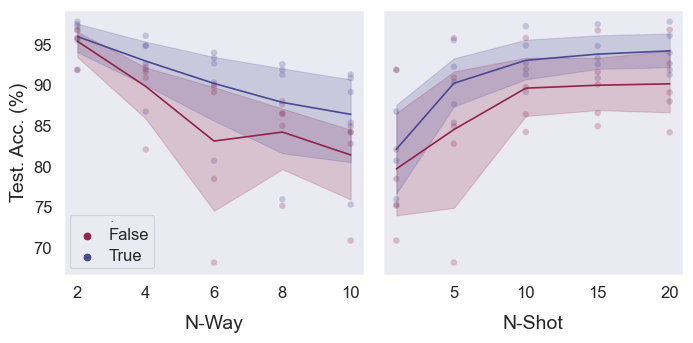

In [124]:
# Set context to paper
sns.set_context("paper")
sns.set_style("dark")

# Plot test/acc vs. n_shot for SOT and non-SOT methods
fig, axs = plt.subplots(ncols=2, figsize=(7, 3.5), sharey=True)

# test/acc ~ n_shot
sns.scatterplot(
    data=df_best_runs,
    x=("config", "n_way"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    alpha=0.25,
    legend=True,
    ax=axs[0],
)
sns.lineplot(
    data=df_best_runs,
    x=("config", "n_way"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    legend=False,
    ax=axs[0],
)

# test/acc ~ n_way
sns.scatterplot(
    data=df_best_runs,
    x=("config", "n_shot"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    alpha=0.25,
    legend=False,
    ax=axs[1],
)
sns.lineplot(
    data=df_best_runs,
    x=("config", "n_shot"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    legend=False,
    ax=axs[1],
)

# Set label size
labsize = 14

# Set title of the legend, adjust font size
axs[0].get_legend().set_title("SOT", prop={"size": 1})
for t in axs[0].get_legend().texts:
    t.set_fontsize(12)

# Set axis labels
axs[0].set_xlabel("N-Way", size=labsize)
axs[1].set_xlabel("N-Shot", size=labsize)

# Add padding between label of x-axis and tick labels
axs[0].xaxis.labelpad = 10
axs[1].xaxis.labelpad = 10

# Set axis labels
axs[0].set_ylabel("Test. Acc. (%)", size=labsize)
axs[1].set_ylabel("")

# Make the ticks descroptors bigger
axs[0].tick_params(labelsize=12)
axs[1].tick_params(labelsize=12)

# Set the tight layout
fig.tight_layout(pad=1.0)

# Save figure
name = "way-shot.png" if REPORT else "present-way-shot.png"
fig.savefig(os.path.join(FIGURE_DIR, name), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

✅ Saved figure to /Users/adam/school/epfl/deeplearning_biomedicine/few-shot-benchmark/report/figures.


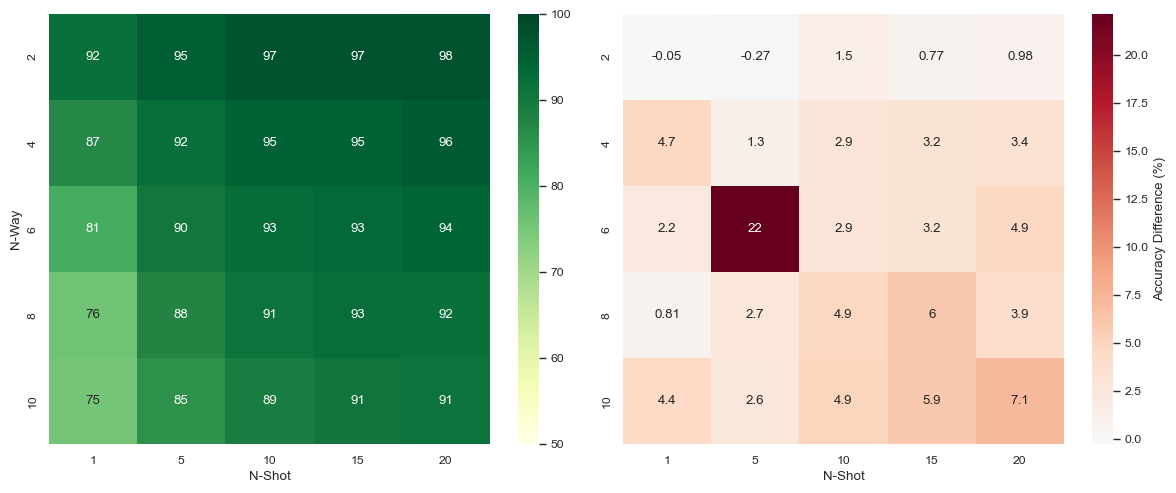

In [125]:
# Get the dataframe with n_way and n_shot, and the test accuracy
way_shot = df_best_runs[
    [
        ("config", "n_way"),
        ("config", "n_shot"),
        ("eval", "test/acc"),
        ("config", "use_sot"),
    ]
]

# Flatten the multi-index
way_shot.columns = way_shot.columns.get_level_values(1)

# Split the dataframe into SOT and non-SOT
way_shot_sot = way_shot[way_shot["use_sot"]].drop(columns=["use_sot"])
way_shot = way_shot[~way_shot["use_sot"]].drop(columns=["use_sot"])

# Group by n_way and n_shot
way_shot = way_shot.groupby(["n_way", "n_shot"]).mean().reset_index()
way_shot_sot = way_shot_sot.groupby(["n_way", "n_shot"]).mean().reset_index()

# Pivot the dataframe
way_shot = way_shot.pivot(index="n_way", columns="n_shot", values="test/acc")
way_shot_sot = way_shot_sot.pivot(
    index="n_way", columns="n_shot", values="test/acc")

# Compute the diff
way_shot_diff = way_shot_sot - way_shot

# Setup the figure
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))


# Plot the heatmap
sns.heatmap(
    way_shot_sot,
    annot=True,
    cmap="YlGn",
    vmin=50,
    vmax=100,
    ax=axs[0],
)

# Plot the heatmap
sns.heatmap(
    way_shot_diff,
    annot=True,
    cmap="RdBu_r",
    ax=axs[1],
    center=0,
    cbar_kws={"label": "Accuracy Difference (%)"},
)
for ax in axs:
    ax.set_xlabel("N-Shot")
    ax.set_ylabel("N-Way")
axs[1].set_ylabel("")

fig.tight_layout(pad=1.0)
name = "way-shot-heatmap" if REPORT else "present-way-shot-heatmap.png"
fig.savefig(os.path.join(FIGURE_DIR, name), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

In [126]:
# Don't run the rest of the notebook
raise ValueError("Don't run the rest of the notebook.")

ValueError: Don't run the rest of the notebook.

## Experiment 3: Understanding model performance

---

The goal of this section will be to understand the behaviour of the SOT module.
We will try to understand the improvements by looking at:

- **Embeddings during forward-pass**. Visualise the embeddings of support and
  query samples during episodes with and without SOT enabled.
- **Visualise the self-optimal transport plan.** Visualise the self-optimal
  transport plan for a few episodes via a heat map.
- **Understand model prediction patterns and errors.** Visualise the model
  predictions and errors for a few episodes with and without SOT enabled.

To get started, we will load two pre-trained models from the benchmarking
experiment. We will use two instances of `protonet` that were both trained on
the `tabula_muris` dataset. The first model was trained with the default
configuration, while the second model was trained with the same configuration
but with the `use_sot` flag set to `True`.


In [ ]:
# Experiments
GROUP = "model-behaviour"

# Filter runs by group
runs = [run for run in runs if run.group == GROUP and run.state == "finished"]
print(f"✅ Loaded {len(runs)} runs")

# Load runs into dataframe
df_runs = utils.load_to_df(runs)
df_runs.head()

In [ ]:
# Initialise data loaders and model
models = []
for run in runs:
    # Load data loaders and model
    train_loader, val_loader, test_loader, model = utils.init_all(run)
    models.append(model)

print(f"✅ Initialised data loader and model.")

In [ ]:
# Download artifact (model weights)
for run in runs:
    if not os.path.exists(os.path.join(ARTIFACT_DIR, run.id)):
        utils.download_artifact(
            api,
            wandb_entity=WANDB_ENTITY,
            wandb_project=WANDB_PROJECT,
            artifact_dir=ARTIFACT_DIR,
            run_id=run.id,
        )
    print(f"✅ Downloaded artifact for run {run.id}.")

In [ ]:
# Load model weights
weight_path = os.path.join(ARTIFACT_DIR, runs[0].id, "best_model.pt")
models[0].load_state_dict(torch.load(weight_path))

weight_path = os.path.join(ARTIFACT_DIR, runs[1].id, "best_model.pt")
models[1].load_state_dict(torch.load(weight_path))

print(f"✅ Loaded all model weights.")

In [ ]:
# Evaluate performance
print("\nEvaluating X...")
models[0].test_loop(train_loader)
models[0].test_loop(val_loader)
models[0].test_loop(test_loader)

print("Evaluating Y...")
models[1].test_loop(train_loader)
models[1].test_loop(val_loader)
models[1].test_loop(test_loader)


print(f"✅ Evaluated both models.")

We have correctly loaded the model weights by confirming the performance on the
`train`, `val` and `test` split for ProtoNet on SwissProt with and without SOT.


### Visualise Embeddings


In [ ]:
# Visualise episode for Protnet w/ SOT
for loader in [train_loader, val_loader, test_loader]:
    utils.visualise_episode(loader, models[1])

In [ ]:
# Visualise episode for Protnet w/o SOT
for loader in [train_loader, val_loader, test_loader]:
    utils.visualise_episode(loader, models[2])

### Visualise SOT transport plan

Here we visualise the self-optimal transport plan for a few episodes.


In [ ]:
# Visualise transport plan of X
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    x, _ = next(iter(loader))
    utils.visualise_transport_plan(x, models[0], ax=ax)

In [ ]:
# Visualise transport plan for ProtoNet w/ SOT w/o SE on splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    x, _ = next(iter(loader))
    utils.visualise_transport_plan(x, models[1], ax=ax)

In [ ]:
# Visualise transport plan for Baseline w/ SOT on splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    x, _ = next(iter(loader))
    utils.visualise_transport_plan(x, models[2], ax=ax)

In [ ]:
# Compare transport plan of ProtoNet w/ and w/o SE and w/ SOT
fig, axs = plt.subplots(ncols=3, figsize=(16, 5))
fig.tight_layout(pad=3.0)

x, _ = next(iter(test_loader))

utils.visualise_transport_plan(x, models[0], ax=axs[0])
utils.visualise_transport_plan(x, models[1], ax=axs[2])

print()

In [ ]:
# Compare transport plan of ProtoNet with Baseline on test split
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
fig.tight_layout(pad=3.0)

x, _ = next(iter(test_loader))
utils.visualise_transport_plan(x, models[1], ax=axs[0])
utils.visualise_transport_plan(x, models[2], ax=axs[1])

# Remove heatbar from axs[0]
bar = axs[0].collections[0].colorbar
axs[0].collections[0].colorbar.remove()
axs[1].collections[0].colorbar.remove()
pn_acc = axs[0].title.get_text().split(" ")[-1]
b_acc = axs[1].title.get_text().split(" ")[-1]
axs[0].set_title(f"ProtoNet SOT Embeddings (Acc. = {pn_acc}", fontsize=14)
axs[1].set_title(f"Baseline SOT Embeddings (Acc. = {b_acc}", fontsize=14)

# Add colbar in between the two plots
# axs[0].figure.colorbar(bar, ax=axs, location="right")p
cbar_ax = fig.add_axes([0.485, 0.25, 0.02, 0.5])
fig.colorbar(axs[0].collections[0], cax=cbar_ax, orientation="vertical")

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "sot-embeddings.png"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

### Visualise confusion patterns

p fig.subplots_adjust(bottom=0.2)


In [ ]:
# Confusion matrix for Protonet w/ SOT on all splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    utils.visualise_confusion_matrix(loader, models[0], ax=ax)

In [ ]:
# Confusion matrix for Protonet w/o SOT on all splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    utils.visualise_confusion_matrix(loader, models[1], ax=ax)